<a href="https://colab.research.google.com/github/eunzzae/Off_Study_ML/blob/main/231030_%EC%8B%A4%EC%8A%B5%EC%BD%94%EB%93%9C_%5BAIBootcamp_06%5DLSTM101_Stock_Price_Prediction_20231027.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- torch Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [4]:
!pip install finance-datareader torchinfo

In [5]:
import FinanceDataReader as fdr

In [6]:
# 삼성전자(005930) 전체
# 카카오(035720)
#index = '035720'
index = '005930'
samsung = fdr.DataReader(symbol=index, start='1990-01-01', end='2023-12-31')
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-07-13,2930,3250,2930,3130,1627833,NaN
1999-07-14,3150,3240,3100,3140,1251715,0.003195
1999-07-15,3200,3390,3170,3360,1447788,0.070064
1999-07-16,3380,3540,3380,3450,1388163,0.026786
1999-07-19,3600,3619,3360,3460,1148678,0.002899
...,...,...,...,...,...,...
2023-10-24,68700,68800,67700,68500,12791710,0.001462
2023-10-25,68800,68800,67900,68000,10610703,-0.007299
2023-10-26,67000,67900,66700,66700,15517624,-0.019118


매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [7]:
samsung.index

DatetimeIndex(['1999-07-13', '1999-07-14', '1999-07-15', '1999-07-16',
               '1999-07-19', '1999-07-20', '1999-07-21', '1999-07-22',
               '1999-07-23', '1999-07-26',
               ...
               '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26',
               '2023-10-27', '2023-10-30'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

## 시각화

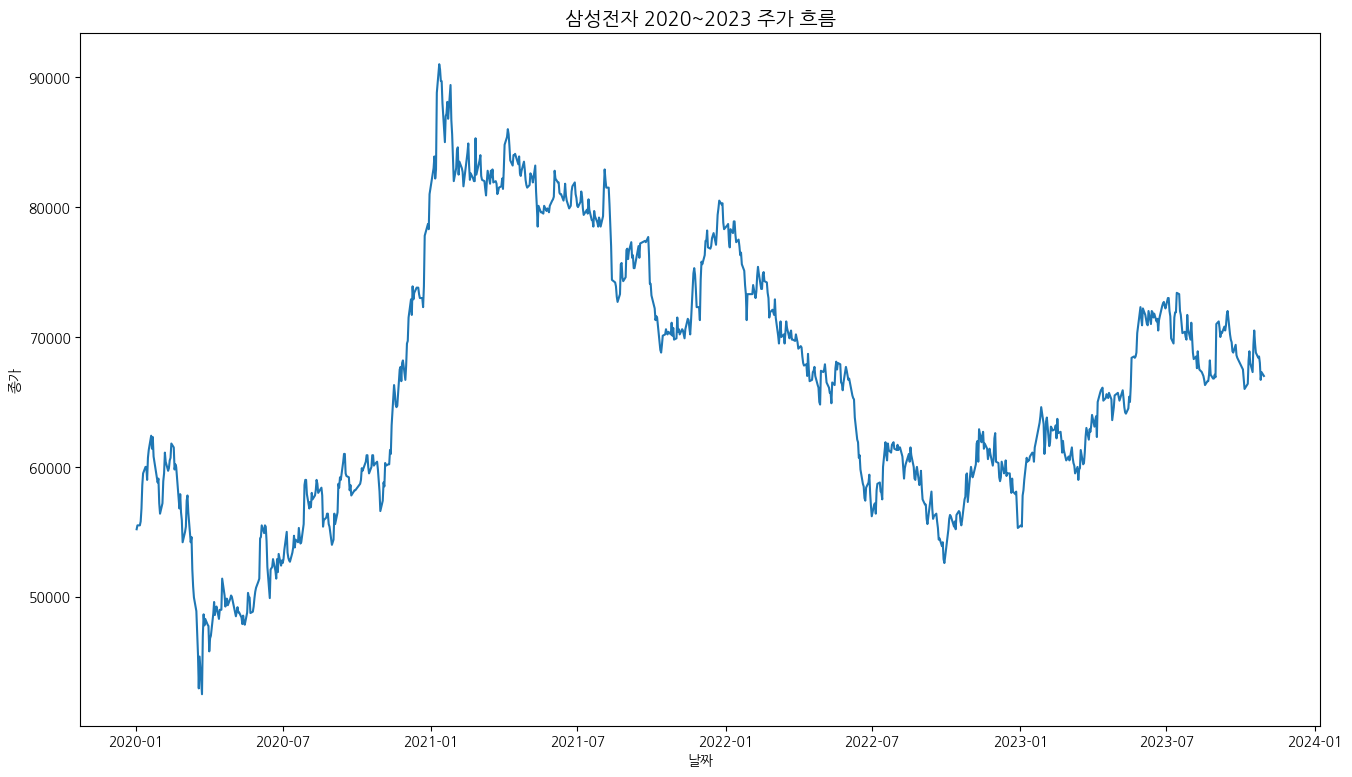

In [8]:
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(16, 9))
plt.title("삼성전자 2020~2023 주가 흐름", fontsize=14)
#plt.title("카카오 1999~2023 주가 흐름", fontsize=14)
sns.lineplot(data=samsung.loc[samsung.index > '20200101'], x='Date', y="Close")
plt.xlabel('날짜')
plt.ylabel('종가')
plt.show()

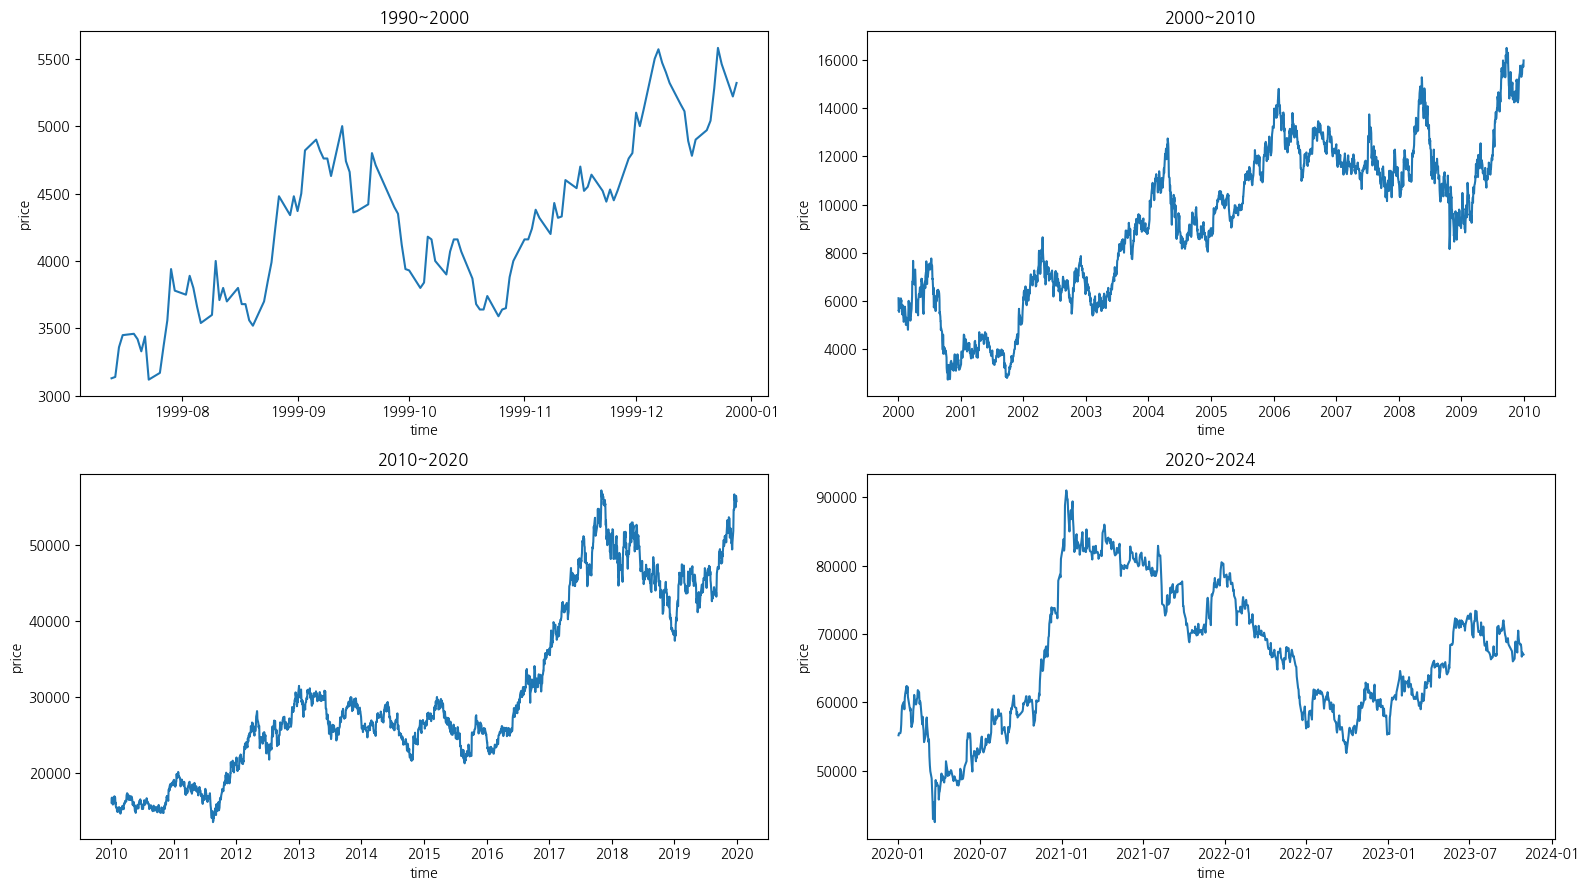

In [9]:
time_steps = [['1990', '2000'],
              ['2000', '2010'],
              ['2010', '2020'],
              ['2020', '2024']] # COVID-19

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = samsung.loc[(samsung.index > time_steps[i][0]) & (samsung.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [37]:
# for binary classification
samsung['label'] = (samsung['Change'] >= 0) * 1

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Volume', 'Close']
# 스케일 후 columns
df = samsung.loc[samsung.index > '20200101', scale_cols]
scaled = scaler.fit_transform(df)
scaled

array([[0.27044025, 0.23380282, 0.2690678 , 0.12016274, 0.26185567],
       [0.28092243, 0.24507042, 0.26694915, 0.14780557, 0.26804124],
       [0.25786164, 0.22629108, 0.26059322, 0.08927371, 0.26804124],
       ...,
       [0.5115304 , 0.457277  , 0.51694915, 0.14889088, 0.49896907],
       [0.51362683, 0.44600939, 0.51694915, 0.10128864, 0.51134021],
       [0.50733753, 0.44225352, 0.51694915, 0.        , 0.50515464]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [11]:
df = pd.DataFrame(scaled, columns=scale_cols, index=df.index)
df

,Open,High,Low,Volume,Close
Date,,,,,
2020-01-02,0.270440,0.233803,0.269068,0.120163,0.261856
2020-01-03,0.280922,0.245070,0.266949,0.147806,0.268041
2020-01-06,0.257862,0.226291,0.260593,0.089274,0.268041
2020-01-07,0.274633,0.241315,0.281780,0.086210,0.274227
2020-01-08,0.285115,0.260094,0.288136,0.239745,0.294845
...,...,...,...,...,...
2023-10-24,0.547170,0.474178,0.538136,0.117869,0.536082
2023-10-25,0.549266,0.474178,0.542373,0.093049,0.525773
2023-10-26,0.511530,0.457277,0.516949,0.148891,0.498969


## train / test 분할

- 2021년 이전까지의 모든 데이터로, 2022년을 예측해봅니다.


- 시계열 예측에서는 "예측 당시"에는 미래의 데이터를 모릅니다. 그래서 train 데이터는 무조건 test 데이터보다 시기적으로 **과거**여야합니다.

In [12]:
train = df.loc[df.index < '20230101']
###### 분류 시 변경 ######
X_train, y_train = train.drop("Close", axis=1), train.Close
test = df.loc[df.index > '20230101']
X_test, y_test = test.drop("Close", axis=1), test.Close
###### 분류 시 변경 ######
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(742, 4) (742,) (203, 4) (203,)


In [13]:
X_train

,Open,High,Low,Volume
Date,,,,
2020-01-02,0.270440,0.233803,0.269068,0.120163
2020-01-03,0.280922,0.245070,0.266949,0.147806
2020-01-06,0.257862,0.226291,0.260593,0.089274
2020-01-07,0.274633,0.241315,0.281780,0.086210
2020-01-08,0.285115,0.260094,0.288136,0.239745
...,...,...,...,...
2022-12-23,0.327044,0.278873,0.326271,0.084158
2022-12-26,0.322851,0.273239,0.326271,0.049186
2022-12-27,0.322851,0.278873,0.330508,0.093690


In [14]:
y_test[:31]

Date
2023-01-02    0.268041
2023-01-03    0.265979
2023-01-04    0.315464
2023-01-05    0.323711
2023-01-06    0.340206
2023-01-09    0.375258
2023-01-10    0.369072
2023-01-11    0.371134
2023-01-12    0.371134
2023-01-13    0.377320
2023-01-16    0.383505
2023-01-17    0.381443
2023-01-18    0.369072
2023-01-19    0.391753
2023-01-20    0.397938
2023-01-25    0.430928
2023-01-26    0.441237
2023-01-27    0.455670
2023-01-30    0.428866
2023-01-31    0.381443
2023-02-01    0.397938
2023-02-02    0.432990
2023-02-03    0.439175
2023-02-06    0.393814
2023-02-07    0.400000
2023-02-08    0.424742
2023-02-09    0.422680
2023-02-10    0.418557
2023-02-13    0.420619
2023-02-14    0.426804
2023-02-15    0.406186
Name: Close, dtype: float64

## Data Preparation

In [15]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

seq_length = 30
batch_size = 32

# 20200102
# ...
# ...
# 20200214(open,high,low,close)
# -----> 20200215 (close)


# 데이터셋 생성 함수
def build_dataset(X, y, seq_length):

    X_data = []
    y_data = []

    for idx in range(0, len(X)-seq_length):
        # idx = 0 ~ len(X)-seq_length-1
        _X = X[idx:idx+seq_length] # 30개 feature vectors
        _y = y[idx+seq_length] # 1개 (31번째 target value, close)
        ###### 분류 시 변경 ######
        ## target value도 잘 만들어봅시다 ##
        ###### 분류 시 변경 ######
        #print(_X, '--->', _y)
        X_data.append(_X.values)
        y_data.append(_y)

    X_data = torch.FloatTensor(np.array(X_data))
    y_data = torch.FloatTensor(np.array(y_data))

    return X_data, y_data

trainX, trainY = build_dataset(X_train, y_train, seq_length)
testX, testY = build_dataset(X_test, y_test, seq_length)

# 텐서로 변환

# 텐서 형태로 데이터 정의
trainset = TensorDataset(trainX, trainY)
testset = TensorDataset(testX, testY)


# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
trainloader = DataLoader(trainset,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

testloader = DataLoader(testset,
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=True)

## Define Model

In [28]:
class LSTM(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, n_layers):
        super().__init__()
        self.input_dim = input_dim      # input feature vector dim
        self.hidden_dim = hidden_dim    # hidden layer node 개수 (= hidden state dim)
        self.seq_len = seq_len          # hidden state 개수 (=input sequence length)
        self.output_dim = output_dim    # output layer의 node 개수 (=output dim)
        self.n_layers = n_layers        # multi-layer로 구성할 때, (hidden, LSTM)layer 수

        self.lstm = nn.LSTM(input_size=input_dim, # Wxh   (input_dim x hidden_dim)
                            hidden_size=hidden_dim, # Whh (hidden_dim x hidden_dim)
                            num_layers=n_layers,
                            batch_first=True,
                            dropout=0.1, # hidden layer의 node중에 일부를 deactivate 시킴.
                            bidirectional=False)  # (batch_size, ~~~~)

        # input_dim = 4
        # hidden_dim = 10

        # LSTM1 = Wxh(4x10)
        # LSTM2 = Wxh(10x10)
        # ... = Wxh(10x10)
        # ...
        #

        self.fc = nn.Linear(in_features=hidden_dim,
                            out_features=output_dim) # Why

        # self.fc2 = nn.Linear(5, output_dim)

        ###### 분류 시 변경 ######

        ######### TO-DO ###########
        # output layer를 디자인해봅시다.
        self.output = nn.Sigmoid()   # if, output_dim = 1
        # self.output = nn.Softmax()   3 if, output_dim = 2
        ###### 분류 시 변경 ######


        # self.rnn = nn.RNN(input_size=4,
        #                   hidden_size=10,
        #                   num_layers=1,
        #                   batch_first=True)
        # self.fc = nn.Linear(10, 1)

    # 예측을 위한 함수
    def forward(self, x):  # (N, L, H_in)
        # (n_layers, batch_size, hidden_dim)
        # h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        # c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        # input : (x, (h0, c0))
        # output : (x, (hn, cn))
        # x, (hn, cn) = self.lstm(x, (h0, c0))  # (N, L, H_in) ---(LSTM)---> (N, L, H_out)

        x, _ = self.lstm(x) # h0, c0를 zero vector로 init.

        # e.g. (batch_size, seq_len, hidden_dim)
        ## 마지막 출력결과(last_hidden_state) ---> (batch_size, hidden_dim)
        x = self.fc(x[:, -1, :]) # (batch_size, hidden_dim) ---> (batch_size, output_dim)  ## Linear Regression
        x = self.output(x) # Logistic Regression (2차원으로 한다면 Softmax 사용)
        x = x.view(-1, ) # make 2d tensor to 1d tensor(2차원은 불가능)
        return x

In [29]:
tX, ty = next(iter(trainloader))
tX.shape, ty.shape # (batch_size, seq_len, input_dim) ## (N, L, H_in)

(torch.Size([32, 30, 4]), torch.Size([32]))

In [33]:
model = LSTM(input_dim=4,
             hidden_dim=10,
             seq_len=30,
             output_dim=1,
             n_layers=1)
output = model(tX)
output.view(-1, )

tensor([0.5316, 0.5370, 0.5294, 0.5315, 0.5355, 0.5250, 0.5266, 0.5292, 0.5284,
        0.5305, 0.5284, 0.5330, 0.5302, 0.5283, 0.5354, 0.5312, 0.5298, 0.5305,
        0.5305, 0.5355, 0.5278, 0.5350, 0.5314, 0.5305, 0.5291, 0.5306, 0.5340,
        0.5497, 0.5367, 0.5268, 0.5306, 0.5331], grad_fn=<ViewBackward0>)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
# 설정값
input_dim = 4
hidden_dim = 10
output_dim = 1
learning_rate = 1e-3
n_epochs = 15
n_layers = 1

In [21]:
# define model
model = LSTM(input_dim=input_dim,
             hidden_dim=hidden_dim,
             seq_len=seq_length,
             output_dim=output_dim,
             n_layers=n_layers).to(device)
model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (lstm): LSTM(4, 10, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [22]:
# regression
criterion = nn.MSELoss()   ###### 분류 시 변경 ######
# criterion = nn.BCELoss()  # for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
from tqdm.auto import tqdm
for epoch in tqdm(range(n_epochs)):
    for idx, data in enumerate(trainloader):
        optimizer.zero_grad()

        X, y = data[0].to(device), data[1].to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} ---> Train loss : {loss.item():.4f}")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 ---> Train loss : 0.2341
Epoch 1 ---> Train loss : 0.1098
Epoch 2 ---> Train loss : 0.0760
Epoch 3 ---> Train loss : 0.0566
Epoch 4 ---> Train loss : 0.0587
Epoch 5 ---> Train loss : 0.0588
Epoch 6 ---> Train loss : 0.0409
Epoch 7 ---> Train loss : 0.0652
Epoch 8 ---> Train loss : 0.0479
Epoch 9 ---> Train loss : 0.0520
Epoch 10 ---> Train loss : 0.0526
Epoch 11 ---> Train loss : 0.0370
Epoch 12 ---> Train loss : 0.0477
Epoch 13 ---> Train loss : 0.0496
Epoch 14 ---> Train loss : 0.0555


In [25]:
def train_model(model, train_df, n_epochs = None, lr = None, verbose = 10, patience = 10):

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

    return model, train_hist

IndentationError: ignored

In [ ]:
# 모델 학습
model, train_hist =

In [ ]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

## 예측 데이터 시각화

In [ ]:
# 예측 테스트


avg_loss = avg_loss / len(testloader)
print("Test MSE : %.4f" % avg_loss)

In [ ]:
plot_data = [pred + label for pred, label in zip(preds, labels)]
plot_data